In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the image
image_path = 'lena.jpg'
image = cv2.imread(image_path)

In [3]:
# Convert BGR to RGB 
rgb_image = image[:, :, ::-1]

# Convert RGB to grayscale
def rgb_to_grayscale(rgb_image):
    r, g, b = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2]
    gray_image = 0.299 * r + 0.587 * g + 0.114 * b  # Convert using the luminance method
    return gray_image

lena_gray = rgb_to_grayscale(rgb_image)

In [4]:
# Sobel filter X and Y gradients
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

In [5]:
# Get dimensions of filter and image
height_filter, width_filter = sobel_x.shape
height_image, width_image = lena_gray.shape

In [6]:
# Calculate output dimensions after convolution
height_output = height_image - height_filter + 1
width_output = width_image - width_filter + 1

In [7]:
# Initialize arrays for gradient images
gradient_x = np.zeros((height_output, width_output))
gradient_y = np.zeros((height_output, width_output))

In [8]:
# Apply Sobel filters using convolution
for i in range(height_output):
    for j in range(width_output):
        current_window = lena_gray[i:i + height_filter, j:j + width_filter]
        gradient_x[i, j] = np.sum(current_window * sobel_x)
        gradient_y[i, j] = np.sum(current_window * sobel_y)

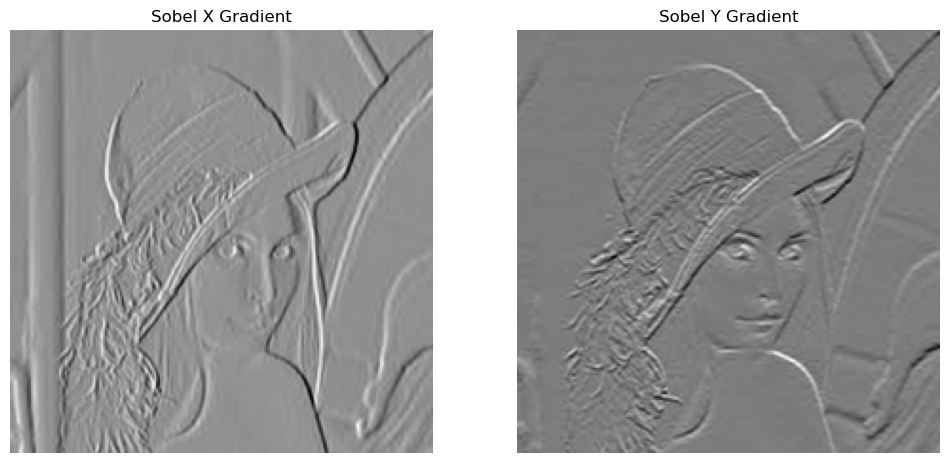

In [9]:
# Display the gradient images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gradient_x, cmap='gray')
plt.title('Sobel X Gradient')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradient_y, cmap='gray')
plt.title('Sobel Y Gradient')
plt.axis('off')

plt.show()

In [10]:
# Calculate the magnitude of the gradients
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

In [11]:
# Normalize the gradient magnitude to the range [0, 255] for display
gradient_magnitude = (gradient_magnitude / np.max(gradient_magnitude)) * 255

In [12]:
# Convert to uint8
gradient_magnitude = gradient_magnitude.astype(np.uint8)

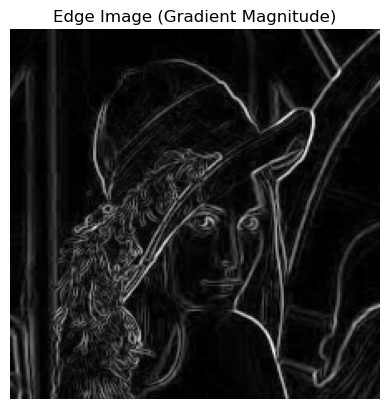

In [13]:
# Display the gradient magnitude image
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Edge Image (Gradient Magnitude)')
plt.axis('off')
plt.show()

In [14]:
# Compute gradient direction
gradient_direction = np.arctan2(gradient_y, gradient_x)

In [15]:
# Non-Maximum Suppression
def non_maximum_suppression(magnitude, direction):
    image_height, image_width = magnitude.shape
    output = [[0 for _ in range(image_width)] for _ in range(image_height)]  # Initializing output
    angle = direction * 180.0 / np.pi  # Convert radians to degrees
    angle[angle < 0] += 180  # Adjust angle range

    # According to the gradient direction, select the corresponding neighbor pixel for comparison
    for i in range(1, image_height - 1):
        for j in range(1, image_width - 1):
            q = 255
            r = 255

            # Angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] < 180):
                q = magnitude[i, j + 1]
                r = magnitude[i, j - 1]
            # Angle 45
            elif 22.5 <= angle[i, j] < 67.5:
                q = magnitude[i + 1, j - 1]
                r = magnitude[i - 1, j + 1]
            # Angle 90
            elif 67.5 <= angle[i, j] < 112.5:
                q = magnitude[i + 1, j]
                r = magnitude[i - 1, j]
            # Angle 135
            elif 112.5 <= angle[i, j] < 157.5:
                q = magnitude[i - 1, j - 1]
                r = magnitude[i + 1, j + 1]

            if (magnitude[i, j] >= q) and (magnitude[i, j] >= r):
                output[i][j] = magnitude[i, j]
            else:
                output[i][j] = 0

    return np.array(output, dtype=np.uint8)

In [16]:
# Double Thresholding
def apply_threshold(image, low, high):
    height, width = image.shape
    thresholded = [[0] * width for _ in range(height)]  # Initialize manually
    strong, weak = 255, 75

    for i in range(height):
        for j in range(width):
            if image[i, j] >= high:
                thresholded[i][j] = strong
            elif image[i, j] >= low:
                thresholded[i][j] = weak

    return np.array(thresholded, dtype=np.uint8)

In [17]:
# Hysteresis
def edge_tracking_by_hysteresis(image, weak=75, strong=255):
    height, width = image.shape
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if image[i, j] == weak:
                if any(image[i + a, j + b] == strong for a in [-1, 0, 1] for b in [-1, 0, 1] if (a, b) != (0, 0)):
                    image[i, j] = strong
                else:
                    image[i, j] = 0
    return image

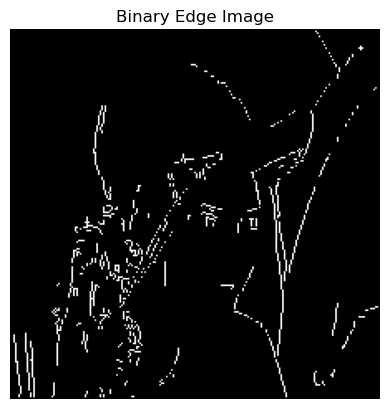

In [18]:
# Apply Non-Maximum Suppression
nms_image = non_maximum_suppression(gradient_magnitude, gradient_direction)

# Apply Double Threshold
low_threshold = 50
high_threshold = 100
threshold_image = apply_threshold(nms_image, low_threshold, high_threshold)

# Apply Hysteresis
edge_image = edge_tracking_by_hysteresis(threshold_image)

# Display the binary edge image
plt.imshow(edge_image, cmap='gray')
plt.title('Binary Edge Image')
plt.axis('off')
plt.show()